# Computing the (dense) optical flow with OpenCV

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os

In [2]:
def load_frame(prefix):
    fn = f"{prefix}.png"
    frame = cv2.imread(fn, cv2.IMREAD_UNCHANGED) # [rows, cols, comp]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(frame)
    frame = frame.astype(np.float32) - 32768.0
    frame = frame.astype(np.int16)
    return frame

In [3]:
prefix = "/home/vruiz/MRVC/sequences/stockholm/"
R = load_frame(prefix + "000")
P = load_frame(prefix + "001")

In [4]:
def RGB_to_YCoCg(RGB_frame):
    R, G, B = RGB_frame[:,:,0], RGB_frame[:,:,1], RGB_frame[:,:,2]
    YCoCg_frame = np.empty_like(RGB_frame)
    YCoCg_frame[:,:,0] =  R/4 + G/2 + B/4 
    YCoCg_frame[:,:,1] =  R/2       - B/2
    YCoCg_frame[:,:,2] = -R/4 + G/2 - B/4
    return YCoCg_frame

In [5]:
R = RGB_to_YCoCg(R)[:,:,0]
P = RGB_to_YCoCg(P)[:,:,0]

In [6]:
def show(img, title, fn=None):
    #plt.figure(figsize = (10,10))
    plt.title(title)
    plt.imshow((img-img.min())/(img.max()-img.min()), cmap="gray")
    if fn != None:
        plt.savefig(fn, dpi=200)

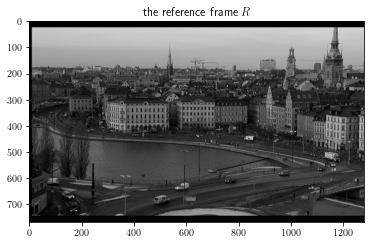

In [7]:
show(R, "the reference frame $R$", "R.svg")

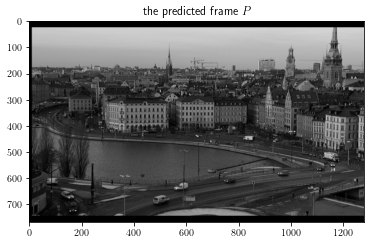

In [8]:
show(P, "the predicted frame $P$", "P.svg")

In [9]:
flow = cv2.calcOpticalFlowFarneback(
    prev=P,        # Be carefull
    next=R,        # with this!
    flow=None,
    pyr_scale=0.5,
    levels=3,      # Play
    winsize=7,     # with
    iterations=3,  # this
    poly_n=5,
    poly_sigma=1.2,
    flags=0)

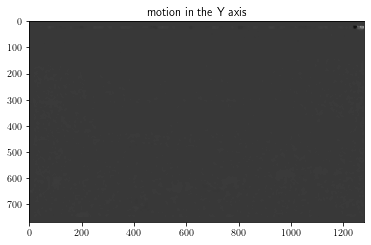

In [10]:
show(flow[:,:,0], "motion in the Y axis", "y_motion.svg")

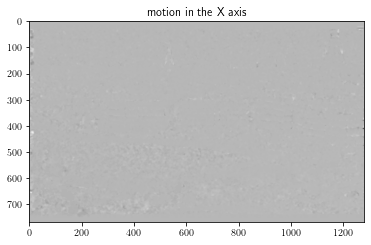

In [11]:
show(flow[:,:,1], "motion in the X axis", "x_motion.svg")

In [12]:
def estimate_frame(reference, flow):
    height, width = flow.shape[:2]
    map_x = np.tile(np.arange(width), (height, 1))
    map_y = np.swapaxes(np.tile(np.arange(height), (width, 1)), 0, 1)
    map_xy = (flow + np.dstack((map_x, map_y))).astype('float32')
    return cv2.remap(reference, map_xy, None, 
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_REPLICATE)

In [13]:
hat_P = estimate_frame(R, flow)

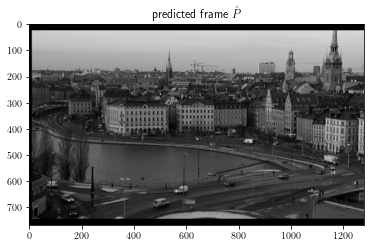

In [14]:
show(hat_P, "predicted frame $\hat{P}$", "hat_P.svg")

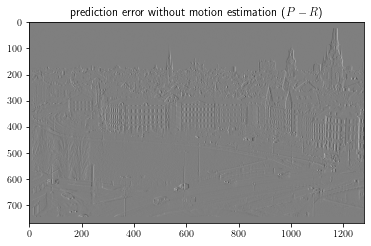

In [15]:
show(P-R, "prediction error without motion estimation ($P-R$)", "without_ME.svg")

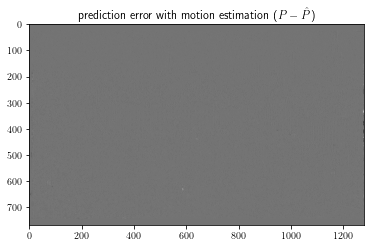

In [16]:
show(P-hat_P, "prediction error with motion estimation ($P-\hat{P}$)", "with_ME.svg")